In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    LabelEncoder,
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    balanced_accuracy_score,
    average_precision_score,
    log_loss,
    zero_one_loss,
)

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

In [3]:
data = pd.read_csv("dataset.csv")

target = ["health"]

cat_cols = [
    "curb_loc",
    "spc_common",
    "guards",
    "sidewalk",
    "user_type",
]

OHE_cols = [
    "curb_loc",
    "guards",
    "sidewalk",
    "user_type",
    "borough",
]

TE_cols = [
    "spc_common",
]

num_cols = [
    "block_id",
    "tree_dbh",
    "steward",
    "postcode",
    "cncldist",
    "st_senate",
    "nta",
    "ct",
    "x_sp",
    "y_sp",
    "problems",
    "root_problems",
    "trunk_problems",
    "brch_problems",
]

feature_cols = num_cols + cat_cols
target_col = ["health"]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650797 entries, 0 to 650796
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   block_id        650797 non-null  int64  
 1   tree_dbh        650797 non-null  int64  
 2   curb_loc        650797 non-null  object 
 3   health          650797 non-null  object 
 4   spc_common      650797 non-null  object 
 5   steward         650797 non-null  float64
 6   guards          650797 non-null  object 
 7   sidewalk        650797 non-null  object 
 8   user_type       650797 non-null  object 
 9   problems        650797 non-null  int64  
 10  postcode        650797 non-null  int64  
 11  borough         650797 non-null  object 
 12  cncldist        650797 non-null  int64  
 13  st_senate       650797 non-null  int64  
 14  nta             650797 non-null  int64  
 15  x_sp            650797 non-null  float64
 16  y_sp            650797 non-null  float64
 17  root_probl

In [5]:
X = data.drop(columns=target)
y = data[target]

target_le = LabelEncoder()
y = target_le.fit_transform(y.squeeze()).astype(int)

X, X_test, y, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [6]:
categories_list = [X[col].unique().tolist() for col in OHE_cols + TE_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ("scaler", StandardScaler(), num_cols),
        (
            "OHE",
            OneHotEncoder(
                sparse_output=False, drop="first", categories=categories_list
            ),
            OHE_cols + TE_cols,
        ),
    ],
)

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

X_train

array([[-1.8035878 ,  0.39831577, -0.52581452, ...,  0.        ,
         0.        ,  0.        ],
       [-0.07529668, -0.19896229, -0.52581452, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0279503 , -1.15460718,  1.245901  , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.74296218, -0.91569595, -0.52581452, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.75919135, -0.67678473, -0.52581452, ...,  0.        ,
         0.        ,  0.        ],
       [-1.79607956,  0.39831577,  3.60818837, ...,  0.        ,
         0.        ,  0.        ]])

In [7]:
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.LongTensor(y_train)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.LongTensor(y_val)
X_test_t = torch.FloatTensor(X_test)
y_test_t = torch.LongTensor(y_test)

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

In [8]:
def fit_epoch(model, train_loader, criterion, optimizer):
    torch.manual_seed(SEED)
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [9]:
def eval_epoch(model, val_loader, criterion):
    torch.manual_seed(SEED)
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().double() / processed_size
    return val_loss, val_acc

In [10]:
def train(
    train_dataset, val_dataset, model, epochs, opt, criterion, scheduler, batch_size
):
    torch.manual_seed(SEED)

    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    best_model = model.state_dict()
    best_acc = 0
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(
                log_template.format(
                    ep=epoch + 1,
                    t_loss=train_loss,
                    v_loss=val_loss,
                    t_acc=train_acc,
                    v_acc=val_acc,
                )
            )

            if best_acc < val_acc:
                best_acc = val_acc
                best_model = model.state_dict()

            scheduler.step()

    model.load_state_dict(best_model)
    return history

In [11]:
def predict(model, test_loader):
    torch.manual_seed(SEED)
    with torch.no_grad():
        logits = []

        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [13]:
def get_metrics(y_true, y_pred, pred_proba):
    cm = confusion_matrix(y_true, y_pred)

    accuracy = accuracy_score(y_true, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    average_precision = average_precision_score(y_true, pred_proba)
    f1 = f1_score(y_true, y_pred, average="weighted")
    l_loss = log_loss(y_true, pred_proba)
    zo_loss = zero_one_loss(y_true, y_pred)

    ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=target_le.classes_
    ).plot()
    print("Accuracy:", accuracy)
    print("Balanced accuracy:", balanced_accuracy)
    print("Average precision:", average_precision)
    print("F1 Score:", f1)
    print("log_loss", l_loss)
    print("zo_loss", zo_loss)

In [14]:
class MLPBlock(nn.Module):
    def __init__(self, in_dim, out_dim, dropout_prob):
        super(MLPBlock, self).__init__()
        self.fc = nn.Linear(in_dim, out_dim)
        self.bn = nn.BatchNorm1d(out_dim)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = self.fc(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        return x


class TreeCensusModel(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_prob):
        super(TreeCensusModel, self).__init__()

        self.layer1 = MLPBlock(input_dim, 256, dropout_prob)
        self.layer2 = MLPBlock(256, 512, dropout_prob)
        self.layer3 = MLPBlock(512, 512, dropout_prob)
        self.layer4 = MLPBlock(512, 1024, dropout_prob)
        self.layer5 = MLPBlock(1024, 512, dropout_prob)
        self.layer6 = MLPBlock(512, 256, dropout_prob)
        self.layer7 = MLPBlock(256, 256, dropout_prob)
        self.layer8 = MLPBlock(256, 64, dropout_prob)
        self.fc = nn.Linear(64, output_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.fc(x)
        return x

In [16]:
model = TreeCensusModel(
    input_dim=X_train_t.shape[1], output_dim=len(y_train_t.unique()), dropout_prob=0.3
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=3, gamma=0.2)

model.to(DEVICE)
history = train(
    train_dataset,
    val_dataset,
    model=model,
    epochs=15,
    opt=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    batch_size=256,
)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 0.6495344085407653


epoch:   7%|▋         | 1/15 [00:12<03:01, 12.98s/it]


Epoch 001 train_loss: 0.6495 val_loss 0.5614 train_acc 0.7891 val_acc 0.8104
loss 0.5462003801025254


epoch:  13%|█▎        | 2/15 [00:24<02:33, 11.83s/it]


Epoch 002 train_loss: 0.5462 val_loss 0.5440 train_acc 0.8110 val_acc 0.8112
loss 0.5370688322792171


epoch:  20%|██        | 3/15 [00:35<02:18, 11.54s/it]


Epoch 003 train_loss: 0.5371 val_loss 0.5392 train_acc 0.8114 val_acc 0.8115
loss 0.524425575753586


epoch:  27%|██▋       | 4/15 [00:46<02:06, 11.53s/it]


Epoch 004 train_loss: 0.5244 val_loss 0.5320 train_acc 0.8124 val_acc 0.8117
loss 0.5188715876208754


epoch:  33%|███▎      | 5/15 [00:59<01:58, 11.86s/it]


Epoch 005 train_loss: 0.5189 val_loss 0.5307 train_acc 0.8129 val_acc 0.8118
loss 0.5134643613289692


epoch:  40%|████      | 6/15 [01:10<01:45, 11.74s/it]


Epoch 006 train_loss: 0.5135 val_loss 0.5296 train_acc 0.8136 val_acc 0.8116
loss 0.5054625238157295


epoch:  47%|████▋     | 7/15 [01:22<01:34, 11.81s/it]


Epoch 007 train_loss: 0.5055 val_loss 0.5282 train_acc 0.8148 val_acc 0.8120
loss 0.5028101858302251


epoch:  53%|█████▎    | 8/15 [01:34<01:22, 11.72s/it]


Epoch 008 train_loss: 0.5028 val_loss 0.5281 train_acc 0.8152 val_acc 0.8119
loss 0.5006819652113882


epoch:  60%|██████    | 9/15 [01:45<01:10, 11.71s/it]


Epoch 009 train_loss: 0.5007 val_loss 0.5281 train_acc 0.8156 val_acc 0.8119
loss 0.49820129417550024


epoch:  67%|██████▋   | 10/15 [01:57<00:58, 11.68s/it]


Epoch 010 train_loss: 0.4982 val_loss 0.5274 train_acc 0.8161 val_acc 0.8123
loss 0.4975119994166102


epoch:  73%|███████▎  | 11/15 [02:08<00:45, 11.48s/it]


Epoch 011 train_loss: 0.4975 val_loss 0.5273 train_acc 0.8162 val_acc 0.8123
loss 0.4969935762501973


epoch:  80%|████████  | 12/15 [02:19<00:34, 11.41s/it]


Epoch 012 train_loss: 0.4970 val_loss 0.5273 train_acc 0.8163 val_acc 0.8124
loss 0.4963914484404631


epoch:  87%|████████▋ | 13/15 [02:31<00:23, 11.51s/it]


Epoch 013 train_loss: 0.4964 val_loss 0.5271 train_acc 0.8163 val_acc 0.8125
loss 0.49623789408570035


epoch:  93%|█████████▎| 14/15 [02:42<00:11, 11.49s/it]


Epoch 014 train_loss: 0.4962 val_loss 0.5270 train_acc 0.8164 val_acc 0.8126
loss 0.4961250664436338


epoch: 100%|██████████| 15/15 [02:54<00:00, 11.62s/it]


Epoch 015 train_loss: 0.4961 val_loss 0.5270 train_acc 0.8164 val_acc 0.8127


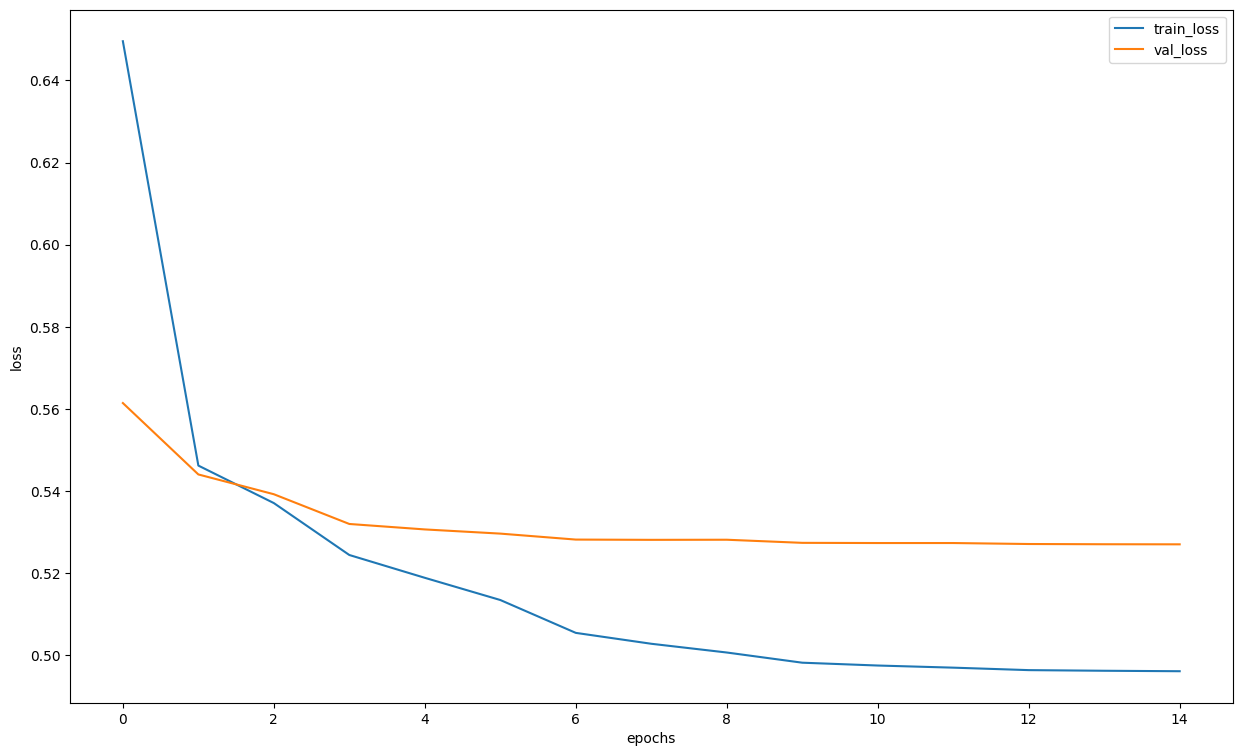

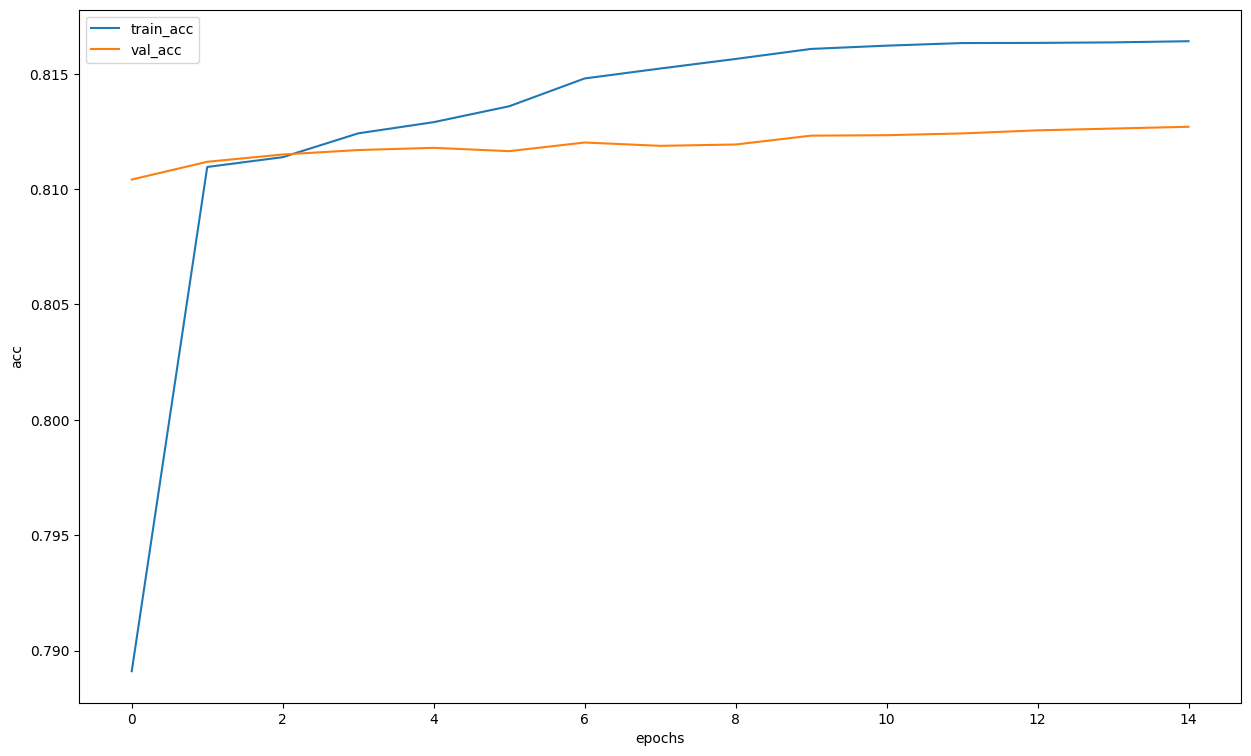

Accuracy: 0.8127016748617086
Balanced accuracy: 0.3645641721494834
Average precision: 0.4541893389361516
F1 Score: 0.7494039804856508
log_loss 0.5270238584208232
zo_loss 0.18729832513829137


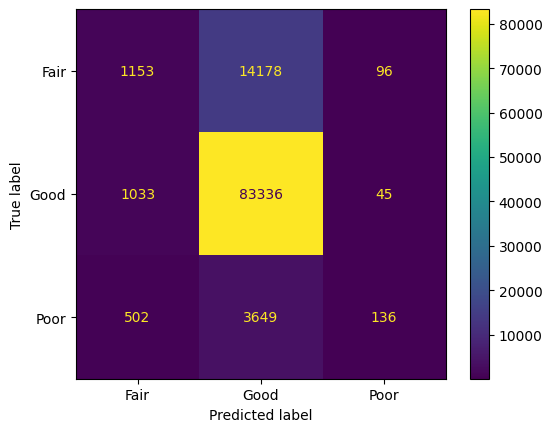

In [21]:
loss, acc, val_loss, val_acc = zip(*history)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)
probs = predict(model, val_loader)

y_pred_proba = probs
y_pred = np.argmax(probs, axis=1)

get_metrics(y_val, y_pred, y_pred_proba)

Accuracy: 0.8120774431468961
Balanced accuracy: 0.3621283238235708
Average precision: 0.4526123087304806
F1 Score: 0.747736424646675
log_loss 0.5269301398537837
zo_loss 0.18792255685310388


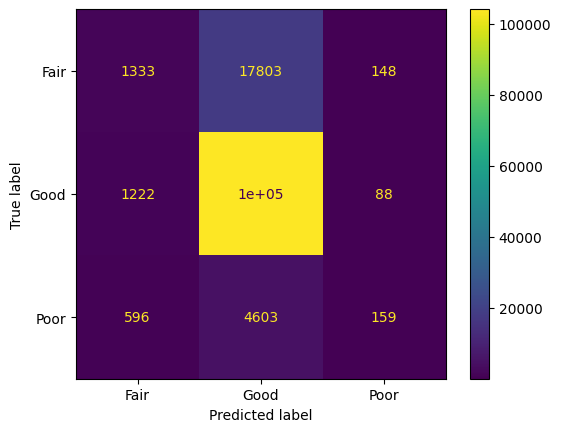

In [20]:
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)
probs = predict(model, test_loader)

y_pred_proba = probs
y_pred = np.argmax(probs, axis=1)

get_metrics(y_test, y_pred, y_pred_proba)